# Adaptive PDE discretizations on cartesian grids 
## Volume : GPU accelerated methods
## Part : Eikonal equations, acceleration and reproducibility
## Chapter : Rander metrics

In this notebook, we solve Rander eikonal equations on the CPU and the GPU, and check that they produce consistent results.

*Note on the numerical schemes*: The numerical schemes solved by the CPU and GPU in the Rander case are entirely different. The CPU version uses a causal semi-Lagrangian scheme, two dimensional only, whereas the GPU version uses a non-causal (yet monotone) Eulerian scheme, in two and three dimensions.

In [18]:
large_instances = False # True favors the GPU code (CPU times may become a big long.)
strong_anisotropy = True # True favors the CPU code 
anisotropy_bound = 20. if strong_anisotropy else 5. # Ratio between the fastest and the smallest velocity at any given point

[**Summary**](Summary.ipynb) of volume GPU accelerated methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Two dimensions](#1.-Two-dimensions)
    * [1.1 Constant metric](#1.1-Constant-metric)
    * [1.2 Zermelo's problem](#1.2-Zermelo's-problem)
  * [2. Three dimensions](#2.-Three-dimensions)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research.
The author would like to acknowledge fruitful informal discussions with L. Gayraud on the 
topic of GPU coding and optimization.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [2]:
import sys; sys.path.insert(0,"..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Rander_Repro','GPU'))

In [3]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [4]:
from agd import HFMUtils
from agd import AutomaticDifferentiation as ad
from agd import Metrics
from agd import FiniteDifferences as fd
from agd import LinearParallel as lp
import agd.AutomaticDifferentiation.cupy_generic as cugen

from Notebooks_GPU.ExportedCode.Isotropic_Repro import RunCompare

In [5]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global HFMUtils,ad,cugen,RunSmart,Metrics
    HFMUtils,ad,cugen,Metrics = rreload([HFMUtils,ad,cugen,Metrics],"../..")    
    HFMUtils.dictIn.RunSmart = cugen.cupy_get_args(HFMUtils.RunSmart,dtype64=True,iterables=(dict,Metrics.Base))

In [6]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)
HFMUtils.dictIn.RunSmart = cugen.cupy_get_args(HFMUtils.RunSmart,dtype64=True,iterables=(dict,Metrics.Base))

## 1. Two dimensions

### 1.1 Constant metric

In [13]:
n=200
hfmIn = HFMUtils.dictIn({
    'model':'Rander2',
    'seeds':cp.array([[0.,0.]]),
    'exportValues':1,
    'factoringRadius':20,
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
hfmIn['metric'] = Metrics.Rander(cp.eye(2),cp.array([0.5,0.]) )

Casting output of function array from float64 to float32
Casting output of function eye from float64 to float32
Casting output of function array from float64 to float32


In [15]:
gpuOut,cpuOut = RunCompare(hfmIn,check=0.01)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.014496564865112305 seconds,  and 28 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 2
Fast marching solver completed in 0.089 s.
Solver time (s). GPU : 0.014496564865112305, CPU : 0.174. Device acceleration : 12.002843543904083
Max |gpuValues-cpuValues| :  0.006900822754929203


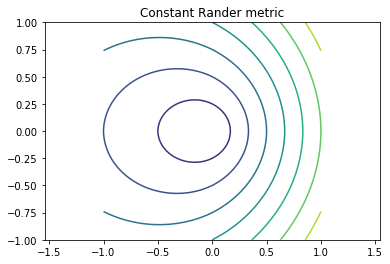

In [16]:
plt.title("Constant Rander metric"); plt.axis('equal')
plt.contour(*hfmIn.Grid(),gpuOut['values']);

### 1.2 Zermelo's problem

We obtain $\times 40$ speedup at resolution $2000\times 2000$ already. The lack of causality does not seem to be a significant issue for the GPU solver. The cost of the FM-ASR adaptive stencils cannot be neglected. 

In [19]:
n=4000 if large_instances else 1000
hfmIn = HFMUtils.dictIn({
    'model':'Rander2',
    'seeds':cp.array([[0.,0.]]),
    'exportValues':1,
})
hfmIn.SetRect([[-2.*np.pi,2.*np.pi],[-2.*np.pi,2.*np.pi]],dimx=n+1)

Casting output of function array from float64 to float32


In [20]:
def Drift(x,mu):
    rho = (mu-1)/(mu+1)
    mult = rho*np.prod(np.sin(x[0])) / np.linalg.norm(x,axis=0)
    mult[np.isnan(mult)]=0.
    return mult*x

In [21]:
hfmIn['metric']=Metrics.Rander.from_Zermelo(cp.eye(2),Drift(hfmIn.Grid(),mu=anisotropy_bound))

Casting output of function eye from float64 to float32


In [22]:
gpuOut,cpuOut = RunCompare(hfmIn,check=0.05);

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.11499786376953125 seconds,  and 157 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 3.148 s.
Solver time (s). GPU : 0.11499786376953125, CPU : 5.255000000000001. Device acceleration : 45.696501028328804
Max |gpuValues-cpuValues| :  0.04047794967481355


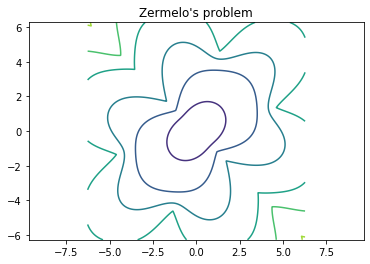

In [23]:
plt.title("Zermelo's problem"); plt.axis('equal')
plt.contour(*hfmIn.Grid(),gpuOut['values']);

In [24]:
n=200; hfmInS = hfmIn.copy() # Define a small instance for validation with multiple options
hfmInS.SetRect([[-2.*np.pi,2.*np.pi],[-2.*np.pi,2.*np.pi]],dimx=n+1)
hfmInS.update({
    'metric' : Metrics.Rander.from_Zermelo(cp.eye(2),Drift(hfmInS.Grid(),mu=anisotropy_bound)),
    'verbosity':0,
    'exportGeodesicFlow':True,
})

Casting output of function eye from float64 to float32


In [25]:
RunCompare(hfmInS,variants='basic',check=0.2)

Solver time (s). GPU : 0.0214993953704834, CPU : 0.181. Device acceleration : 8.418841408372609
Max |gpuValues-cpuValues| :  0.17497343918356023

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.019968509674072266, CPU : 0.188. Device acceleration : 9.414823793490461
Max |gpuValues-cpuValues| :  0.17496580978902898

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.019497156143188477, CPU : 0.189. Device acceleration : 9.693721413111266
Max |gpuValues-cpuValues| :  0.166032610561901

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.025986909866333008, CPU : 0.194. Device acceleration : 7.465296989825409
Max |gpuValues-cpuValues| :  0.16602498116736975


In [26]:
RunCompare(hfmInS,variants='ext',check=0.2)

Solver time (s). GPU : 0.01849842071533203, CPU : 0.183. Device acceleration : 9.892736402536475
Max |gpuValues-cpuValues| :  0.17497343918356023

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.024497270584106445, CPU : 0.186. Device acceleration : 7.59268259545105
Max |gpuValues-cpuValues| :  0.17496580978902898

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.020999431610107422, CPU : 0.194. Device acceleration : 9.238345284861147
Max |gpuValues-cpuValues| :  0.166032610561901

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.02649402618408203, CPU : 0.186. Device acceleration : 7.020450523739246
Max |gpuValues-cpuValues| :  0.16602498116736975

 --- Variant {'factoringRadius': 10.0, 'factoringPointChoice': 'Key'} ---
Solver time (s). GPU : 0.0229799747467041, CPU : 0.195. Device acceleration : 8.485649011775692
Max |gpuValues-cpuValues| :  0.1333969217801627

 --- Variant {'factoringRadius': 10.0, 'factoringPoint

## 2. Three dimensions

As mentioned in the introduction, the CPU variant does not handle three dimensional problems. We generalize here Zermelo's problem, for the sake of testing array broadcasting.

In [39]:
n=200
hfmIn = HFMUtils.dictIn({
    'model':'Rander3',
    'seeds':cp.array([[0.,0.,0.]]),
    'exportValues':1,
    'raiseOnNonConvergence':False,
})
side = [-2.*np.pi,2.*np.pi]
hfmIn.SetRect([side,side,side],dimx=n+1)

Casting output of function array from float64 to float32


In [47]:
hfmIn['metric']=Metrics.Rander.from_Zermelo(cp.eye(3),Drift(hfmIn.Grid(),mu=anisotropy_bound))

Casting output of function eye from float64 to float32


In [48]:
gpuOut = hfmIn.RunGPU()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.5689942836761475 seconds,  and 97 iterations.
Post-Processing
